In [509]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("Lenny_1024.png").convert('RGB')

import torch
import torch.nn.functional as F
from torchvision import transforms as tf

transforms = tf.Compose([tf.ToTensor()])
img_tensor: torch.Tensor = transforms(image)

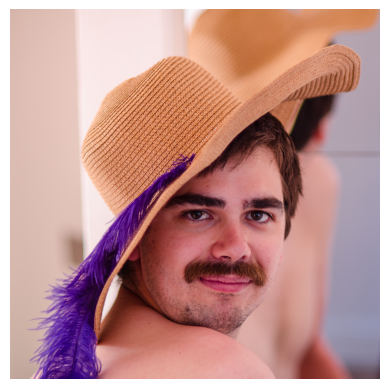

In [510]:
def show_tensor_image(tensor_img: torch.Tensor, grey=False):
    plt.axis('off')
    if grey:
        plt.gray()
    assert 2 <= len(tensor_img.shape) <= 3, "Image should have two or three dimensions"
    if len(tensor_img.shape) == 3:
        plt.imshow(tensor_img.permute(1, 2, 0))
    else:
        plt.imshow(tensor_img)
    
show_tensor_image(img_tensor)

In [511]:
def convert_to_grayscale(tensor_image: torch.Tensor):
    red = 0.299
    green = 0.587
    blue = 0.114
    weights = torch.Tensor([red, green, blue]).reshape(1, 3, 1, 1)
    greyscale_image = F.conv2d(tensor_image, weights)
    return greyscale_image

In [512]:
img_greyscale = convert_to_grayscale(img_tensor)

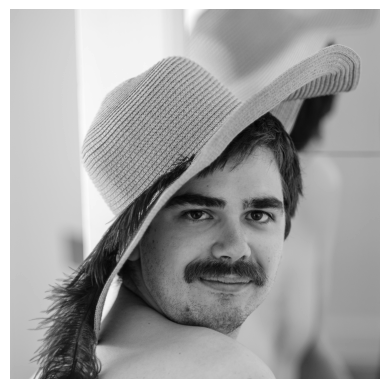

In [513]:
show_tensor_image(img_greyscale, grey=True)

In [514]:
def image_pooling(tensor_image: torch.Tensor, method: str = "max"):
    assert method in ["max", "avg"], 'Possible pooling methods are ["max", "avg"]'
    pooling_fun = F.max_pool2d if method == "max" else F.avg_pool2d
    pooled_image = pooling_fun(tensor_image, kernel_size=4)
    return pooled_image

In [515]:
img_pooled = image_pooling(img_greyscale, "avg")

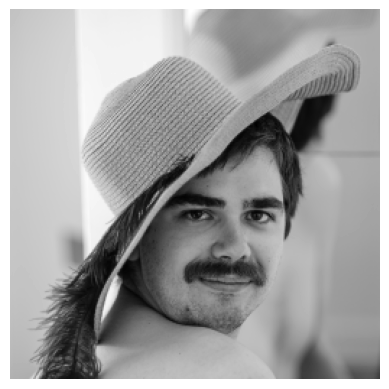

In [516]:
show_tensor_image(img_pooled)

In [517]:
def draw_kernel(kernel):
    plt.axis('off')
    plt.imshow(kernel, cmap='magma')

def create_gaussian_kernel(n: int, sigma: float = 1.0):
    assert 0 < n and type(n) == int, "Kernel size should be a positive natural number"
    assert n % 2, "Kernel size should be an odd number"
    
    half = (n // 2)
    x = torch.arange(-half, half + 1)
    y = torch.arange(-half, half + 1)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    denominator = 2*sigma**2
    normal = torch.exp(-(grid_x.square() + grid_y.square()) / denominator)
    normal = normal / normal.sum()
    return normal

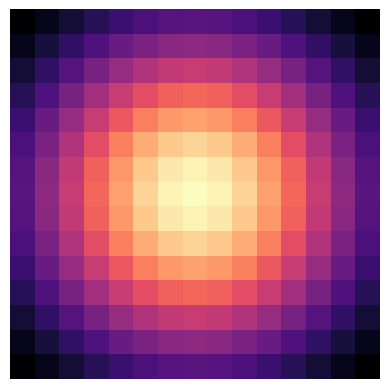

In [518]:
draw_kernel(create_gaussian_kernel(9, sigma=2))
draw_kernel(create_gaussian_kernel(15, sigma=5))

In [530]:
def gaussian_blur(grayscale_image: torch.Tensor, kernel_size: int = 5, kernel_sigma: float = 0.1):
    kernel = create_gaussian_kernel(kernel_size, kernel_sigma).unsqueeze(0).unsqueeze(0)
    blurred_image = F.conv2d(grayscale_image, kernel, stride=1, padding=kernel_size // 2)
    return blurred_image

In [531]:
img_blurred = gaussian_blur(img_pooled)

In [532]:
img_blurred.shape

torch.Size([1, 256, 256])

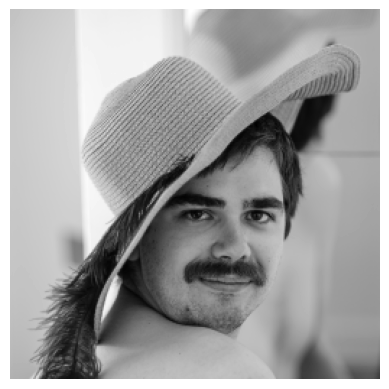

In [533]:
show_tensor_image(img_blurred)

In [534]:
def create_sobel_filters():
    x_scan = torch.tensor([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1],
    ], dtype=torch.float)
    y_scan = x_scan.transpose(0, 1).flip(0)
    sobel_filters = torch.stack((y_scan, x_scan))
    return sobel_filters
    
    
def apply_sobel_filters(tensor_image: torch.Tensor):
    sobel_filters = create_sobel_filters().reshape(2, 1, 3, 3)
    filtered = F.conv2d(tensor_image, sobel_filters, stride=1, padding=1)
    
    norm_channel = (filtered.square().sum(axis=0)).sqrt()
    angle_channel = torch.atan2(*filtered)
    return norm_channel, angle_channel
    # pass

In [535]:
norm, angle = apply_sobel_filters(img_blurred)

In [536]:
def non_max_suppression(img: torch.tensor, D):
    M, N = img.shape
    Z = torch.zeros(img.shape)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255
            #angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = img[i, j+1]
                r = img[i, j-1]
                
            #angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
                
            #angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = img[i+1, j]
                r = img[i-1, j]
            #angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = img[i-1, j-1]
                r = img[i+1, j+1]
            if (img[i,j] >= q) and (img[i,j] >= r):
                Z[i,j] = img[i,j]
            else:
                Z[i,j] = 0
    return Z

In [537]:
tak = non_max_suppression(norm, angle);

In [538]:
# tak = tak / tak.max()
threshold = 0.2

In [539]:
nie = F.relu(tak - threshold) > 0

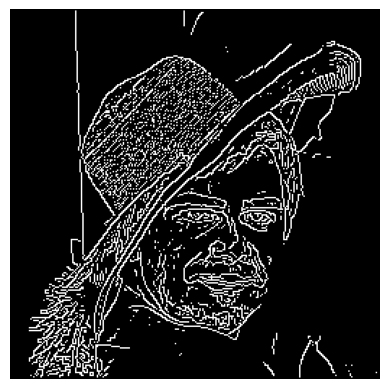

In [541]:
show_tensor_image(nie)

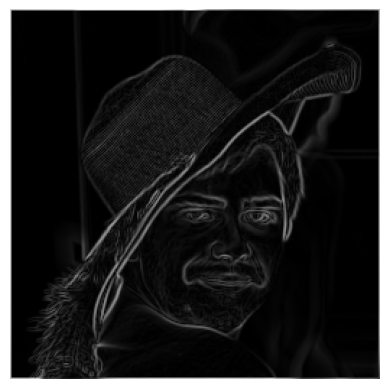

In [542]:
show_tensor_image(norm)

### Opencv implementation

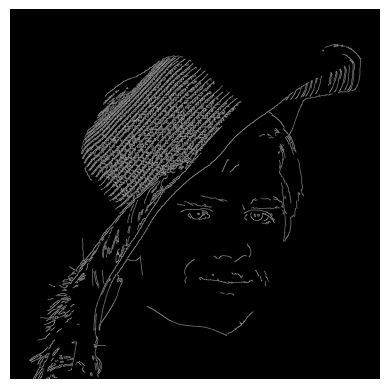

In [543]:
import cv2
canny = cv2.Canny(cv2.GaussianBlur(np.array(image), [3, 3], 0), 100, 200, None, 3, 1)
show_tensor_image(canny)